# Tests módulo `ariaclinprot`

In [1]:
import aclinprot as acp

## Prescripción -> Protocolo Clínico

In [2]:
prescriptionFile = '../../prescripciones/testSBRT.csv'

In [5]:
acp.convertPrescriptionIntoClinicalProtocol(prescription=prescriptionFile, ProtocolID='SBRTPulmon7.5x8', 
                                          TreatmentSite='Lung', PlanID='SBRTPulmon')

## Validación de la prescripción

Validamos la prescripción analizando el protocolo clínico creado a partir de ella.

### Localización de estructuras duplicadas

In [ ]:
acp.searchStructureDuplicates('ClinicalProtocol.xml')

### Parsing el protocolo clínico

In [44]:
import xml.etree.ElementTree as ET
import pandas as pd

In [3]:
bbx = acp.parseProt('ClinicalProtocol.xml')

In [18]:
Phases = bbx.find('Phases')
Phase = Phases.find('Phase')
Prescription = Phase.find('Prescription')

In [125]:
items = []
for Item in Prescription.findall('Item'):
    try:
        itemdict = {
            'Structure': Item.attrib['ID'],
            'Modifier' : Item.find('Modifier').text,
            'Parameter' : Item.find('Parameter').text,
            'TotalDose' : Item.find('TotalDose').text            
        }
        items.append(itemdict)
    except(KeyError):
        pass
itemdf = pd.DataFrame(items)
itemdf = itemdf.astype({'Modifier': int, 'Parameter': float, 'TotalDose': float})
itemdf.sort_values(by=['Structure', 'Modifier'], inplace=True)

In [127]:
itemdf = itemdf.set_index(['Structure', 'TotalDose'])
itemdf

Modifier  Parameter
Structure        TotalDose                     
PTV LSI          57.0              0      95.00
                 64.2              1       5.00
aorta            55.2              1      10.00
                 62.0             10       0.00
arteria pulmonar 55.2              1      10.00
                 62.0             10       0.00
corazon          34.4              1      15.00
                 40.0             10       0.00
esofago          43.2             10       0.00
pared costal     63.0             10       0.00
piel             43.2              1      10.00
                 45.6             10       0.00
plexo braquial   26.4              1       0.35
                 33.6             10       0.00
                 39.2             10       0.00
suma pulmones    15.2              1      37.00
traquea          56.0             10       0.00
v cava inferior  55.2              1      10.00
                 62.0             10       0.00
v cava superior  55.2              1      10.00
                 62.0             10       0.00
venas pulmonares 55.2              1      10.00
                 62.0             10       0.00
via aerea        38.4              1       0.50
                 48.8             10       0.00

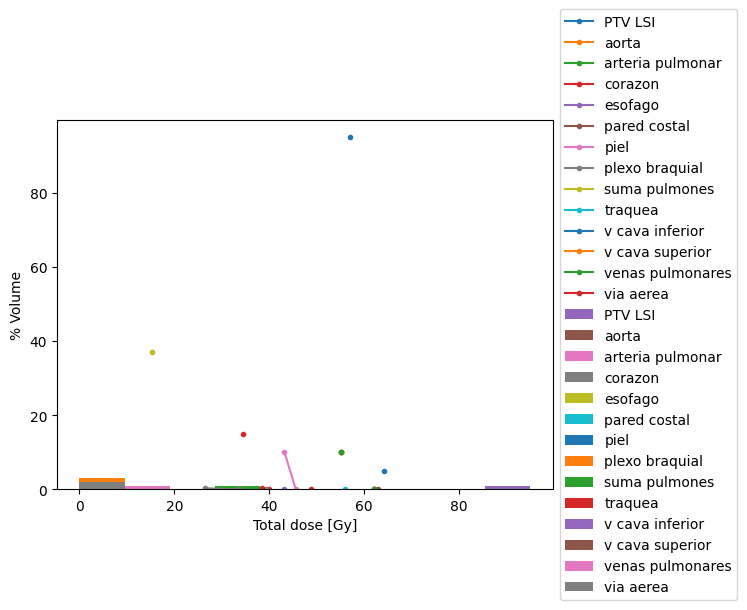

In [156]:
fig, ax = plt.subplots()
restdf = itemdf.unstack(level=0)
restdf.plot(kind='line', y='Parameter', marker='.', ax=ax)
restdf.plot(kind='hist', y='Parameter', ax=ax)
ax.set_ylabel('% Volume')
ax.set_xlabel('Total dose [Gy]')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [122]:
maxdf = itemdf[itemdf.Modifier==10]
maxdf = maxdf.drop('Modifier', axis=1)
maxdf.set_index(['Structure', maxdf.index], inplace=True)
maxdf

Parameter  TotalDose
Structure                                
aorta            11        0.0       62.0
arteria pulmonar 17        0.0       62.0
corazon          9         0.0       40.0
esofago          8         0.0       43.2
pared costal     23        0.0       63.0
piel             21        0.0       45.6
plexo braquial   3         0.0       33.6
                 24        0.0       39.2
traquea          7         0.0       56.0
v cava inferior  13        0.0       62.0
v cava superior  15        0.0       62.0
venas pulmonares 19        0.0       62.0
via aerea        5         0.0       48.8

In [111]:
maxdf.set_index(['Structure', maxdf.index], inplace=True)

In [118]:
maxdf.unstack(level=0)

Parameter                                                     \
Structure     aorta arteria pulmonar corazon esofago pared costal piel   
3               NaN              NaN     NaN     NaN          NaN  NaN   
5               NaN              NaN     NaN     NaN          NaN  NaN   
7               NaN              NaN     NaN     NaN          NaN  NaN   
8               NaN              NaN     NaN     0.0          NaN  NaN   
9               NaN              NaN     0.0     NaN          NaN  NaN   
11              0.0              NaN     NaN     NaN          NaN  NaN   
13              NaN              NaN     NaN     NaN          NaN  NaN   
15              NaN              NaN     NaN     NaN          NaN  NaN   
17              NaN              0.0     NaN     NaN          NaN  NaN   
19              NaN              NaN     NaN     NaN          NaN  NaN   
21              NaN              NaN     NaN     NaN          NaN  0.0   
23              NaN              NaN     NaN     NaN          0.0  NaN   
24              NaN              NaN     NaN     NaN          NaN  NaN   

                                                                  ...  \
Structure plexo braquial traquea v cava inferior v cava superior  ...   
3                    0.0     NaN             NaN             NaN  ...   
5                    NaN     NaN             NaN             NaN  ...   
7                    NaN     0.0             NaN             NaN  ...   
8                    NaN     NaN             NaN             NaN  ...   
9                    NaN     NaN             NaN             NaN  ...   
11                   NaN     NaN             NaN             NaN  ...   
13                   NaN     NaN             0.0             NaN  ...   
15                   NaN     NaN             NaN             0.0  ...   
17                   NaN     NaN             NaN             NaN  ...   
19                   NaN     NaN             NaN             NaN  ...   
21                   NaN     NaN             NaN             NaN  ...   
23                   NaN     NaN             NaN             NaN  ...   
24                   0.0     NaN             NaN             NaN  ...   

          TotalDose                                                    \
Structure   corazon esofago pared costal  piel plexo braquial traquea   
3               NaN     NaN          NaN   NaN           33.6     NaN   
5               NaN     NaN          NaN   NaN            NaN     NaN   
7               NaN     NaN          NaN   NaN            NaN    56.0   
8               NaN    43.2          NaN   NaN            NaN     NaN   
9              40.0     NaN          NaN   NaN            NaN     NaN   
11              NaN     NaN          NaN   NaN            NaN     NaN   
13              NaN     NaN          NaN   NaN            NaN     NaN   
15              NaN     NaN          NaN   NaN            NaN     NaN   
17              NaN     NaN          NaN   NaN            NaN     NaN   
19              NaN     NaN          NaN   NaN            NaN     NaN   
21              NaN     NaN          NaN  45.6            NaN     NaN   
23              NaN     NaN         63.0   NaN            NaN     NaN   
24              NaN     NaN          NaN   NaN           39.2     NaN   

                                                                      
Structure v cava inferior v cava superior venas pulmonares via aerea  
3                     NaN             NaN              NaN       NaN  
5                     NaN             NaN              NaN      48.8  
7                     NaN             NaN              NaN       NaN  
8                     NaN             NaN              NaN       NaN  
9                     NaN             NaN              NaN       NaN  
11                    NaN             NaN              NaN       NaN  
13                   62.0             NaN              NaN       NaN  
15                    NaN            62.0              NaN       NaN

array([<Axes: xlabel='TotalDose', ylabel='Parameter'>], dtype=object)

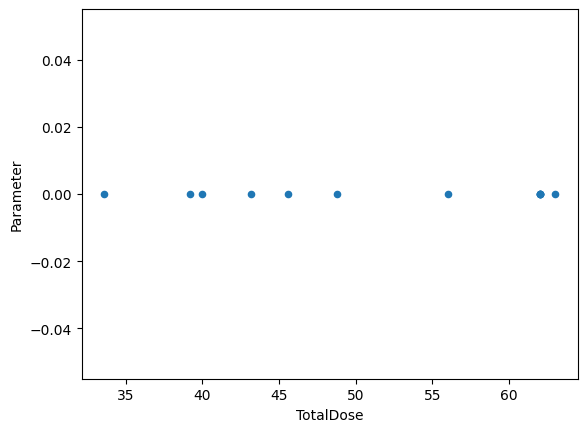

In [119]:
maxdf.unstack(level=0).plot(kind='scatter', x='TotalDose', y='Parameter')

In [76]:
measureitems = []
for MeasureItem in Prescription.findall('MeasureItem'):
    try:
        measureitemdict = {
            'Structure': MeasureItem.attrib['ID'],
            'Type' : MeasureItem.find('Type').text,
            'Modifier' : MeasureItem.find('Modifier').text,
            'Value' : MeasureItem.find('Value').text,            
            'TypeSpecifier' : MeasureItem.find('TypeSpecifier').text,            
            'Absolute' : eval(MeasureItem.find('ReportDQPValueInAbsoluteUnits').text.title())            
        }
        measureitems.append(measureitemdict)
    except(KeyError):
        pass

measureitemdf = pd.DataFrame(measureitems)
measureitemdf = measureitemdf.astype({'Type': int, 
                                      'Modifier': int, 
                                      'Value': float, 
                                      'TypeSpecifier': float})

In [79]:
measureitemdf

,Structure,Type,Modifier,Value,TypeSpecifier,Absolute
0,PTV LSI,2,0,95.00,95.00000,False
1,PTV LSI,2,1,5.00,107.00000,False
2,suma pulmones,2,1,37.00,25.33333,False
3,plexo braquial,2,1,0.35,44.00000,False
4,via aerea,2,1,0.50,64.00000,False
5,corazon,2,1,15.00,57.33333,False
6,aorta,2,1,10.00,92.00000,False
7,v cava inferior,2,1,10.00,92.00000,False
8,v cava superior,2,1,10.00,92.00000,False
9,arteria pulmonar,2,1,10.00,92.00000,False


### Representar el protocolo clínico

In [53]:
import matplotlib.pyplot as plt

## Nombres de estructuras

Correcciones sugeridas en los nombres dados en la prescripción a partir de los que figuran en _Contouring_

In [4]:
strNameSuggestions = acp.suggestStrNames(clinprot='ClinicalProtocol.xml',
                                         rsdicom='../../DICOM/RS.1.2.246.352.221.550136246713487469715724200262812558270.dcm')
strNameSuggestions

,Structure,Suggestion
0,PTV LSI,PTV LSI
1,Ambos pulmones,Ambos pulmones
2,Médula,Médula
3,plexo braquial,Tráquea
4,via aerea,via aerea
5,Tráquea,Tráquea
6,Esófago,Esófago
7,Corazón,Corazón
8,aorta,Corazón
9,v cava inferior,CouchInterior


In [5]:
acceptedChangesIndex = [0,1,2,4,5,6,7,10,11,13,14,15]

In [5]:
strNameChanges = strNameSuggestions.iloc[acceptedChangesIndex]
strNameChanges.columns = ['Old', 'New']
strNameChanges.reindex()
strNameChanges

,Old,New
0,PTV LSI,PTV LSI
1,suma pulmones,Ambos pulmones
2,medula,Médula
4,via aerea,via aerea
5,traquea,Tráquea
6,esofago,Esófago
7,corazon,Corazón
10,v cava superior,Vena cava sup
11,arteria pulmonar,Arteria Pulmonar
13,piel,Piel


Corregir los nombres de las estructuras

In [6]:
acp.correctStrNames(prescriptionFile, strNameChanges)

﻿PrescriptionName,CoverageConstraints,OrgansAtRisk,PrescribedTo
SBRT pulmon 8fx, Volume / Structure :PTV LSI Min Dose:   Gy Max Dose:   Gy At Least 95 % of PTV LSI at 95 % 57 Gy No More Than 5 % of PTV LSI at 107 % 64.2 Gy,"Organ :Ambos pulmones Mean :  Max Dose : 
Constraints : 
D 950cc$14.4 Gy
V15.2$37%
Organ :Médula Mean :  Max Dose : 
Constraints : 
V32$1 cc
Organ :plexo braquial Mean :  Max Dose : 33.6 Gy
Constraints : 
V26.4$0.35 cc
V32.8$3cc
Organ :via aerea Mean :  Max Dose : 48.8 Gy
Constraints : 
V 38.4$0.5 cc
Organ :Tráquea Mean :  Max Dose : 56 Gy
Constraints : 
V50$4 cc
Organ :Esófago Mean :  Max Dose : 43.2 Gy
Constraints : 
V36.8$5cc
Organ :Corazón Mean :  Max Dose : 40 Gy
Constraints : 
V34.4$15 cc
Organ :aorta Mean :  Max Dose : 62 Gy
Constraints : 
V55.2$10cc
Organ :v cava inferior Mean :  Max Dose : 62 Gy
Constraints : 
V55.2$10cc
Organ :Vena cava sup Mean :  Max Dose : 62 Gy
Constraints : 
V55.2$10cc
Organ :Arteria Pulmonar Mean :  Max Dose : 62 Gy
Constraints : 
V5

Volver a generar el protocolo clínico con los nombres correctos de las estructuras

In [7]:
acp.convertPrescriptionIntoClinicalProtocol(prescription=prescriptionFile, ProtocolID='SBRTPulmon7.5x8', 
                                          TreatmentSite='Lung', PlanID='SBRTPulmon')

#### Detalles 
Desglose de los pasos dados para realizar la sugerencia

In [3]:
contstrnames = acp.readContouringStructureNames('../../DICOM/RS.1.2.246.352.221.550136246713487469715724200262812558270.dcm')

Chequear que los nombres de las estructuras es menor de 16 caracteres. Esta una condición requerida por ARIA que utiliza el nombre como identificador de la estructura en el protocolo clínico. 

La siguiente función devuelve una lista con los nombres de las estructuras que no cumplen la condición. La lista está vacía si todas la cumplen

In [4]:
acp.checkStructureNameLength(contstrnames)

[]

Extraer los nombres dados en el Procolo Clínico creado a partir de la prescripción

In [5]:
protstrnames = acp.readClinProtStructureNames('ClinicalProtocol.xml')

Chequear las longitudes

In [6]:
acp.checkStructureNameLength(protstrnames)

[]

Sugerir los cambios de nombre en las estructuras del protocolo según los nombres de las estructuras contorneadas

In [7]:
acp._suggestStrNames(protstrnames, contstrnames)

,Structure,Suggestion
0,PTV LSI,PTV LSI
1,suma pulmones,Ambos pulmones
2,medula,Médula
3,plexo braquial,Tráquea
4,via aerea,via aerea
5,traquea,Tráquea
6,esofago,Esófago
7,corazon,Corazón
8,aorta,Corazón
9,v cava inferior,CouchInterior


Corrección del archivo de la prescripción

Leer el archivo de prescripción

In [7]:
with open(prescriptionFile, 'r') as file:
  filedata = file.read()

In [10]:
def _correctStrNames(filedata, strNameChanges):
    for index, strName in strNameChanges.iterrows():
        filedata.replace(strName.Old, strName.New)
    return filedata

In [ ]:
with open(prescriptionFile, 'w') as file:
  file.write(filedata)

## Prescripciones

In [5]:
%ls ../..

LICENSE*  prescripciones/  protocolos/  README.md*  tools/


In [2]:
pvdf, ccdf, oardf = acp.parse_prescription('../../prescripciones/SBRTPulmon7.5x8.csv')

In [3]:
pvdf

,Volume,Dose,FxDose
0,PTV LSI,60.000,7.500


In [4]:
ccdf

,Volume,Min,Max,AtLeast,NoMore
0,PTV LSI,,,"[95, 95, 57]","[5, 107, 64.2]"


In [5]:
oardf.Dmean = oardf.Dmean.str.strip()
oardf.Dmax = oardf.Dmax.str.strip()
oardf

,Organ,Dmean,Dmax,DosimPars
0,suma pulmones,,,"[D 950cc$14.4 Gy, V15.2$37%]"
1,medula,,,[V32$1 cc]
2,plexo braquial,,33.6 Gy,[V26.4$0.35 cc]
3,via aerea,,48.8 Gy,[V 38.4$0.5 cc]
4,traquea,,56 Gy,[V50$4 cc]
5,esofago,,43.2 Gy,[V36.8$5cc]
6,corazon,,40 Gy,[V34.4$15 cc]
7,aorta,,62 Gy,[V55.2$10cc]
8,v cava inferior,,62 Gy,[V55.2$10cc]
9,v cava superior,,62 Gy,[V55.2$10cc]


In [11]:
oardf.DosimPars.values[1][1]

'V60$30 %'

In [15]:
acp.parseDosimPar(oardf.DosimPars.values[6][0])

{'Vxx': {'Volume%': 30.0, 'DoseGy': 60.0}}

## Escritura de protocolos clínicos

In [14]:
# Read protocol template
bbx = acp.parseProt('BareBone.xml')
# Preview
ProtocolID = 'Laringe'
TreatmentSite = 'Head and Neck'
acp.modPreview(bbx, ID=ProtocolID, TreatmentSite=TreatmentSite)
# Phases
PlanID='ORL'
FractionCount = int(float(pvdf.Dose[0])/float(pvdf.FxDose[0]))
acp.modPhase(bbx, ID=PlanID, vFractionCount=FractionCount)
# Structutures
for pv in pvdf.itertuples():
    acp.addStructure(bbx, structureName=pv.Volume)
for oar in oardf.itertuples():
    acp.addStructure(bbx, structureName=oar.Organ)

# Plan objetives
for pv in pvdf.itertuples():
    ccVolumedf = ccdf[ccdf.Volume == pv.Volume]
    '''
    if not ccVolumedf.Min.str.match(' +')[0]:
        a=1
    if ccVolumedf.Max.str.match(' +')[0] == False:
        a=1
    '''
    if ccVolumedf.AtLeast.values[0]:
        atLeastlst = ccVolumedf.AtLeast.values[0]
        VolumePercentage =  atLeastlst[0]
        DosePercentage = float(atLeastlst[1])/100
        FxDoseGy = float(pv.FxDose) * DosePercentage
        DoseGy = float(pv.Dose) * DosePercentage
        acp.addPlanObjetive(bbx, ID=pv.Volume, vParameter=VolumePercentage,
                            vDose=FxDoseGy, vTotalDose=DoseGy, vModifier=0)
    if ccVolumedf.NoMore.values[0]:
        noMorelst = ccVolumedf.NoMore.values[0]
        VolumePercentage =  noMorelst[0]
        DosePercentage = float(noMorelst[1])/100
        FxDoseGy = float(pv.FxDose) * DosePercentage
        DoseGy = float(pv.Dose) * DosePercentage
        acp.addPlanObjetive(bbx, ID=pv.Volume, vParameter=VolumePercentage,
                            vDose=FxDoseGy, vTotalDose=DoseGy)
for oar in oardf.itertuples():
    if oar.Dmean:
        ID = oar.Organ
        Parameter = 0
        Fxs = float(pvdf.Dose.values[0]) / float(pvdf.FxDose.values[0])
        TotalDose = acp.parseDose(oar.Dmean)
        Dose = f'{TotalDose / Fxs:.5f}'
        acp.addPlanObjetive(bbx, ID=ID, vParameter=Parameter, vDose=Dose, vTotalDose=TotalDose,
                            vModifier=8)
    if oar.Dmax:
        ID = oar.Organ
        Parameter = 0
        Fxs = float(pvdf.Dose.values[0]) / float(pvdf.FxDose.values[0])
        TotalDose = acp.parseDose(oar.Dmax)
        Dose = f'{TotalDose / Fxs:.5f}'
        acp.addPlanObjetive(bbx, ID=ID, vParameter=Parameter, vDose=Dose, vTotalDose=TotalDose,
                            vModifier=10)
    if oar.DosimPars:
        ID = oar.Organ
        for DosimPar in oar.DosimPars:
            constraint_dict = acp.parseDosimPar(DosimPar)
            for key, constraint in constraint_dict.items():
                if key == 'Vxx':
                    VolumePercentage = constraint['Volume%']
                    Fxs = float(pvdf.Dose.values[0]) / float(pvdf.FxDose.values[0])
                    TotalDose = constraint['DoseGy']
                    Dose = f'{TotalDose / Fxs:.5f}'
                    acp.addPlanObjetive(bbx, ID=ID, vParameter=VolumePercentage, vDose=Dose, vTotalDose=TotalDose,
                                        vModifier=1)
                    
# Quality Indexes
for pv in pvdf.itertuples():
    ccVolumedf = ccdf[ccdf.Volume == pv.Volume]
    if ccVolumedf.AtLeast.values[0]:
        TreatmentDosePrescription = acp.getTreatmentDosePrescription(pvdf)
        atLeastlst = ccVolumedf.AtLeast.values[0]
        VolumePercentage =  atLeastlst[0]
        DosePercentage = float(atLeastlst[1])/100
        StructureRelativeDose = float(pv.Dose) * DosePercentage / TreatmentDosePrescription * 100
        acp.addQualityIndex(bbx, ID=pv.Volume, vType=2, vModifier=0, 
                            vValue=VolumePercentage, vTypeSpecifier=StructureRelativeDose, 
                            vReportDQPValueInAbsoluteUnits='false')
    if ccVolumedf.NoMore.values[0]:
        TreatmentDosePrescription = acp.getTreatmentDosePrescription(pvdf)
        noMorelst = ccVolumedf.NoMore.values[0]
        VolumePercentage = noMorelst[0]
        DosePercentage = float(noMorelst[1])/100
        StructureRelativeDose = float(pv.Dose) * DosePercentage / TreatmentDosePrescription * 100
        acp.addQualityIndex(bbx, ID=pv.Volume, vType=2, vModifier=1, 
                            vValue=VolumePercentage, vTypeSpecifier=StructureRelativeDose, 
                            vReportDQPValueInAbsoluteUnits='false')

for oar in oardf.itertuples():
    if oar.DosimPars:
        ID = oar.Organ
        for DosimPar in oar.DosimPars:
            constraint_dict = acp.parseDosimPar(DosimPar)
            for key, constraint in constraint_dict.items():
                if key == 'Vxx':
                    VolumePercentage = constraint['Volume%']
                    PrescriptionDoseGy = pvdf.Dose.astype('float').max()
                    ConstraintDoseGy = constraint['DoseGy']
                    StructureRelativeDose = f'{ConstraintDoseGy / PrescriptionDoseGy * 100:.5f}'
                    acp.addQualityIndex(bbx, ID=ID, vType=2, vModifier=1, 
                                        vValue=VolumePercentage, vTypeSpecifier=StructureRelativeDose, 
                                        vReportDQPValueInAbsoluteUnits='false')
                if key == 'Dxx':
                    VolumePercentage = constraint['Volume%']
                    StructureRelativeDose = constraint['Dose%']
                    acp.addQualityIndex(bbx, ID=ID, vType=4, vModifier=1, 
                                        vValue=VolumePercentage, vTypeSpecifier=StructureRelativeDose, 
                                        vReportDQPValueInAbsoluteUnits='false')

# Write clincial protocol
acp.writeProt(bbx)

In [31]:
pvdf.Dose.astype('float').max()

63.0

In [5]:
bbx = acp.parseProt('BareBone.xml')
TreatmentSite = 'Prostata + vvss hipofx'
acp.modPreview(bbx, ID='ArmaduraTest', TreatmentSite=TreatmentSite)
acp.modPhaseID(bbx, 'Bach')
structureName = 'Recto'
acp.addStructure(bbx, structureName)
acp.addPlanObjetive(bbx, ID=structureName, vParameter=85, vDose=1, vTotalDose=20, vModifier=11)
structureName = 'PTV'
acp.addStructure(bbx, structureName)
acp.addPlanObjetive(bbx, structureName, vParameter=95, vDose=3*.95, vTotalDose=60*.95, vModifier=0, vPrimary='true')
acp.addPlanObjetive(bbx, structureName, vParameter=5, vDose=3*1.07, vTotalDose=60*1.07)
structureName = 'Recto'
acp.addQualityIndex(bbx, ID= structureName, vType=5, vModifier=1, vValue=85, vTypeSpecifier=20, vReportDQPValueInAbsoluteUnits='true')
acp.writeProt(bbx, protout='TestSalida.xml')

In [10]:
import xml.etree.ElementTree as ET

In [11]:
px = ET.parse('Próstata 20Fx.xml')
ET.indent(px)
px.write('Próstata 20Fx.xml', encoding='utf-8', xml_declaration=True)

### Diccionario de estructuras

In [19]:
import pandas as pd

In [31]:
StructureNormalizationdf= pd.DataFrame([
    {'Name' : 'Parotida_D', 'OtherNames' : 'parótida derecha'},
    {'Name' : 'Parotida_I', 'OtherNames' : 'parótida izda'},
    {'Name' : 'Medula', 'OtherNames' : 'médula'},
    {'Name' : 'Medula', 'OtherNames' : 'médula'},
    {'Name' : 'Gland_lagrimal_D', 'OtherNames' : 'glandula lacrimal derecha, glandula lacrimal der, glandula lacrimal dcha, gland lacrimal derecha, gland lacrimal der, gland lacrimal dcha'},
    {'Name' : 'Gland_lagrimal_I', 'OtherNames' : 'glandula lacrimal izquierda, glandula lacrimal izq, glandula lacrimal izqda, gland lacrimal izquierda, gland lacrimal izq, gland lacrimal izqda'},
])
StructureNormalizationdf

,Name,OtherNames
0,Gland_lagrimal_D,"glandula lacrimal derecha, glandula lacrimal d..."
1,Gland_lagrimal_I,"glandula lacrimal izquierda, glandula lacrimal..."


In [32]:
StructureNormalizationdf.OtherNames.str.contains('glandula lacrimal derecha')

0     True
1    False
Name: OtherNames, dtype: bool

In [35]:
StructureNormalizationdf[StructureNormalizationdf.OtherNames.str.contains('glandula lacrimal derecha')].Name.values[0]

'Gland_lagrimal_D'